In [62]:
# Imports.
import torch
import torch.nn as nn 
from torch.utils.data import Dataset as TorchDataset
from torchvision import datasets, transforms
import numpy as np
from  matplotlib import pyplot as plt
from torchvision.transforms import functional as v_F
import os
import natsort
from PIL import Image
import torch.nn.functional as F

In [58]:
# Dataset to store the images. 
class Dataset(TorchDataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [59]:
# Loading the images.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5), std=(0.5))])
paintings = Dataset("./data/monet_jpg", transform)
photos = Dataset("./data/photo_jpg", transform)
paiting_loader = torch.utils.data.DataLoader(paintings, batch_size=32, shuffle=True)
photo_loader = torch.utils.data.DataLoader(paintings, batch_size=32, shuffle=True)

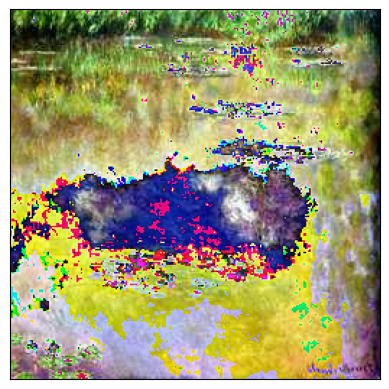

torch.Size([3, 256, 256])


In [63]:
plt.imshow(v_F.to_pil_image(paintings[100]))
plt.xticks([])
plt.yticks([])
plt.show()
print(paintings[0].shape)

In [72]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.lin1 = nn.Linear(in_channels, 128)
        self.lin2 = nn.lInear(128, 256)
        self.lin3 = nn.Linear(256, 512)
        self.lin4 = nn.Linear(512, 1024)
        self.lin5  = nn.Linear(1024, out_channels)
        self.norm1 = nn.BatchNorm1d(256, 0.8)
        self.norm2 =  nn.BatchNorm1d(512, 0.8)
        self.norm3  = nn.BatchNorm1d(1024, 0.8)

    def forward(self, noise_vector):
        x = self.lin1(noise_vector)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.lin2(x)
        x = self.norm1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.lin3(x)
        x = self.norm2(x)
        x = self.lin4(x)
        x = self.norm3(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.lin5(x)
        x = F.tanh(x)
        return x

class Disciminator(nn.Module):
    def __init__(self):
        super().__init__()